In [ ]:
using Pkg; Pkg.add(["Plots", "Distributions"])

In [20]:
using Plots, Distributions, Random

theme(:gruvbox_light)

## Defining the Model

We start by defining our market, represented by:

$$d_t = a - \gamma p \qquad \qquad \gamma > 0$$
$$s_t = b + \beta p_t^* + \epsilon{_t} \qquad \beta > 0$$
$$s_t = d_t$$

Firms, unaware of prevailing prices at the time of production, base their supply decision on the expected price. Assuming adaptive expectations, firms naively choose the most recent prices as the expected market price; hence:
$$p_t^* = p_{t-1}$$

The stability of the model will depend on the slopes of the demand and supply functions, namely $\gamma$ and $\beta$. Prices converge only if $\beta < \gamma$; otherwise, oscillations are explosive.

In [3]:
struct CobwebParams
    a::Float64  # Demand intercept
    γ::Float64  # Demand slope coefficient
    b::Float64  # Supply intercept
    β::Float64  # Supply slope coefficient
    σ::Float64  # Standard deviation of supply shocks
end

In [ ]:
demand(q, params) = (params.a - q) / params.γ   # Inverse demand function
supply(p_prev, params) = params.b + params.β * p_prev

supply (generic function with 1 method)

In [5]:
function cobweb_simulate(params::CobwebParams, T::Int, p0::Float64, stoch::Bool=true)
    prices = zeros(T)
    quantities = zeros(T)
    shocks = zeros(T)
    prices[1] = p0
    quantities[1] = supply(p0, params) + shocks[1]

    if stoch
        shocks = rand(MersenneTwister(42), Normal(0, params.σ), T)
    end
    
    for t in 2:T
        quantities[t] = supply(prices[t-1], params) + shocks[t]
        prices[t] = demand(quantities[t], params)
    end

    return prices, quantities, shocks
end

cobweb_simulate (generic function with 2 methods)

In [ ]:
function cobweb_diagram(params::CobwebParams, p0::Float64, steps::Int)
    p_min, p_max = 0, 10
    p_range = range(p_min, p_max, length=100)
    
    q_demand = params.a .- params.γ * p_range
    q_supply = supply.(p_range, Ref(params))
    
    x_min = max(0, minimum(q_demand), minimum(q_supply))  # Ensure non-negative
    x_max = max(maximum(q_demand), maximum(q_supply))
    
    # Initialize cobweb path
    p_path = [p0]
    q_path = [supply(p0, params)]
    
    # Generate price/quantity path
    for _ in 1:steps
        p_new = demand(last(q_path), params)
        push!(p_path, p_new)
        push!(q_path, last(q_path))
        push!(p_path, p_new)
        push!(q_path, supply(p_new, params))
    end
    
    anim = @animate for i in 1:2*steps
        plot(q_demand, p_range, label="Demand", 
             xlabel="Quantity", ylabel="Price",
             title="Cobweb Diagram (β/γ = $(params.β/params.γ))",
             xlims=(x_min, x_max), ylims=(p_min, p_max),
             dpi=300, legend=:topleft)
        
        plot!(q_supply, p_range, label="Supply")
        
        for j in 1:i
            plot!([q_path[j], q_path[j+1]], [p_path[j], p_path[j+1]], 
                  color=:red, label=(j == 1 ? "Path" : ""), linewidth=1.5)
        end
        
        scatter!(q_path[1:i+1], p_path[1:i+1], 
                 label="Steps", color=:black, markersize=3)
    end
    
    gif(anim, "images/cobweb-deterministic-$(params.β/params.γ).gif", fps=5)
end

cobweb_diagram (generic function with 1 method)

In [7]:
function equilibrium(params::CobwebParams)
    eq_price = (params.a - params.b) / (params.γ + params.β)
    eq_quantity = (params.a * params.β + params.γ * params.b) / (params.γ + params.β)

    return eq_price, eq_quantity
end

equilibrium (generic function with 1 method)

In [8]:
function impulse_response(params::CobwebParams, horizon::Int)
    irf = zeros(horizon)
    for j in 0:horizon - 1
        irf[j+1] = (-1/params.γ) * (-params.β/params.γ)^j
    end
    return irf
end

impulse_response (generic function with 1 method)

## Simulation

In [9]:
params_stable = CobwebParams(10.0, 2.0, 2.0, 1.0, 0.1)  # β/γ = 0.5 < 1
params_unstable = CobwebParams(10.0, 1.0, 2.0, 2.0, 0.1)  # β/γ = 2.0 > 1

T = 100
p0 = 4.0
horizon = 10

10

### Deterministic: Stable

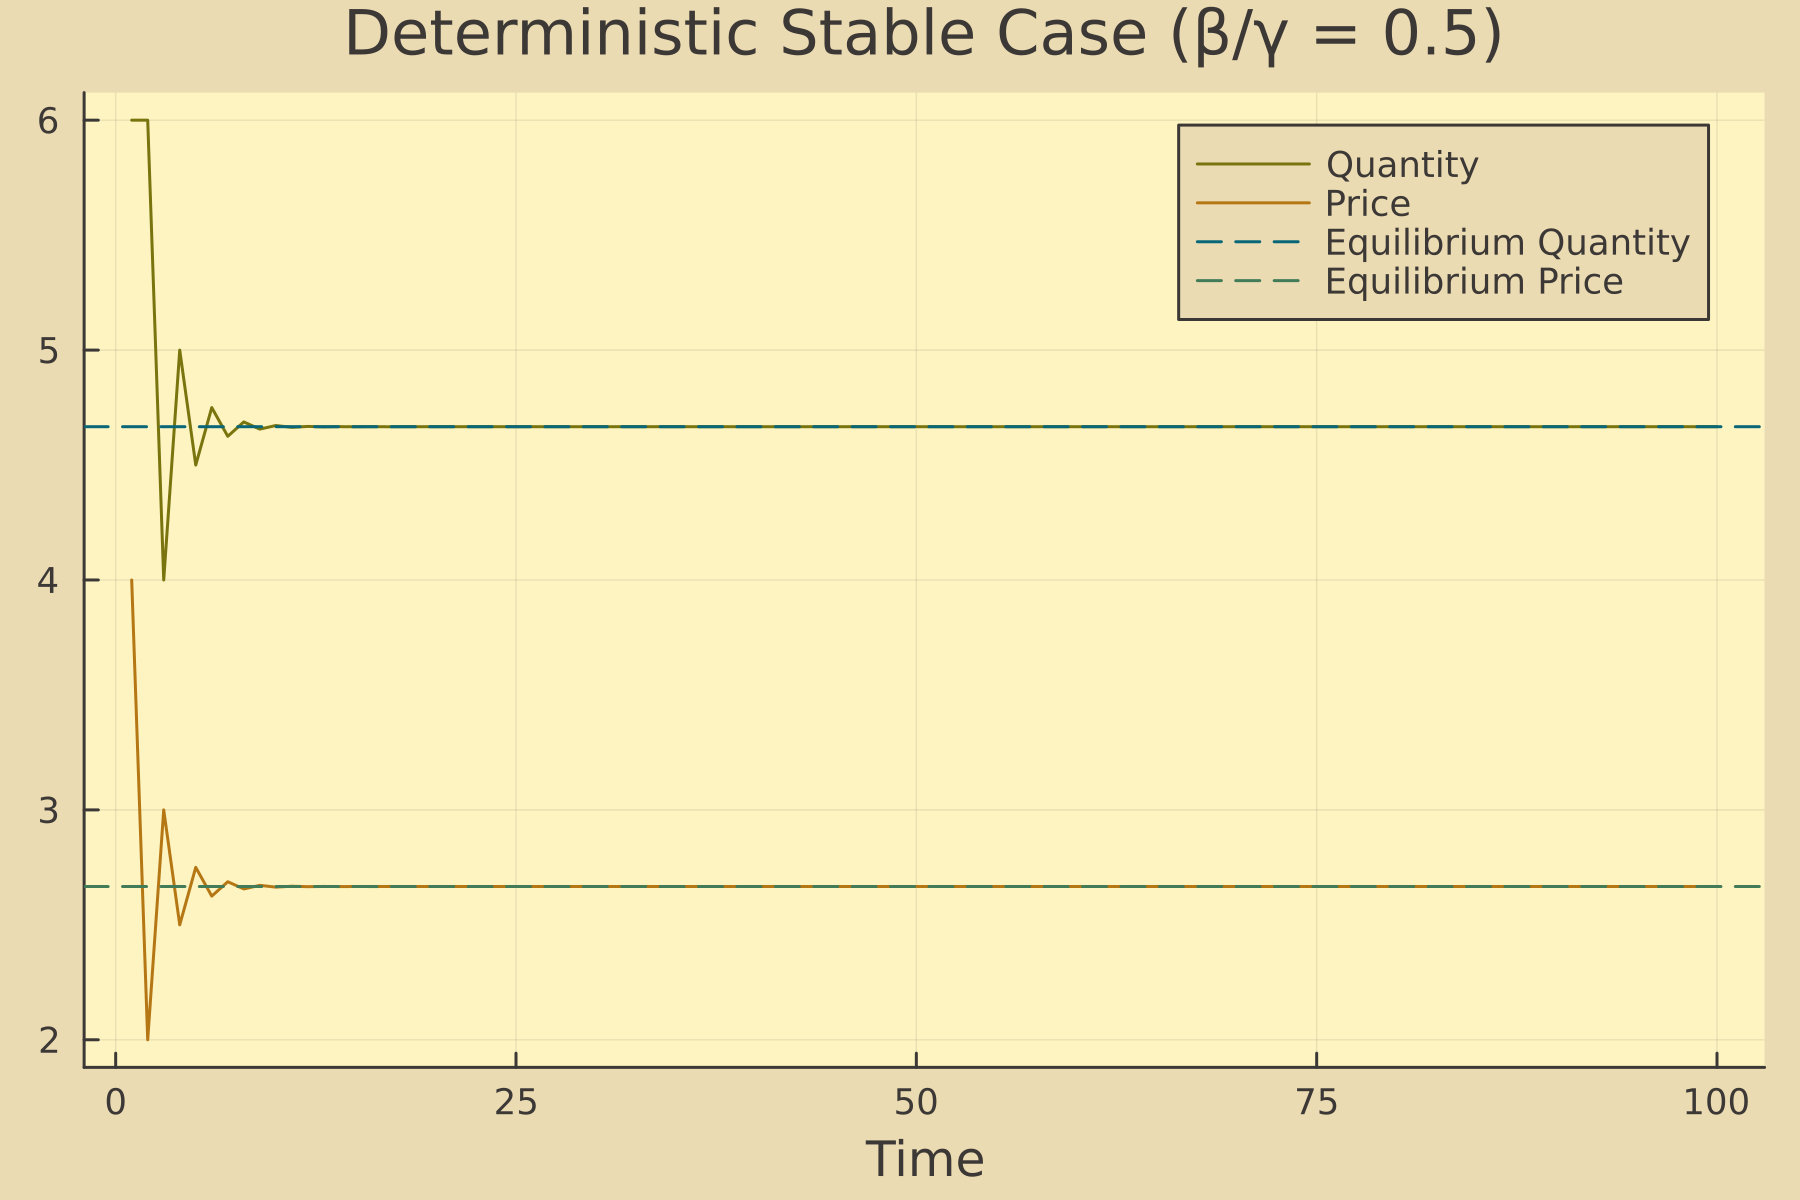

In [32]:
prices_det, quantities_det = cobweb_simulate(params_stable, T, p0, false)
eq_price, eq_quantity = equilibrium(params_stable)

p_det_stable = plot(1:T, quantities_det, label="Quantity", xlabel="Time", title="Deterministic Stable Case (β/γ = 0.5)", dpi=300)
plot!(p_det_stable, 1:T, prices_det, label="Price")
hline!(p_det_stable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_det_stable, [eq_price], label="Equilibrium Price", linestyle=:dash)

┌ Info: Saved animation to d:\Development\Projects\cobweb-model\images\cobweb-deterministic-0.5.gif
└ @ Plots C:\Users\ritob\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\Development\\Projects\\cobweb-model\\images\\cobweb-deterministic-0.5.gif")
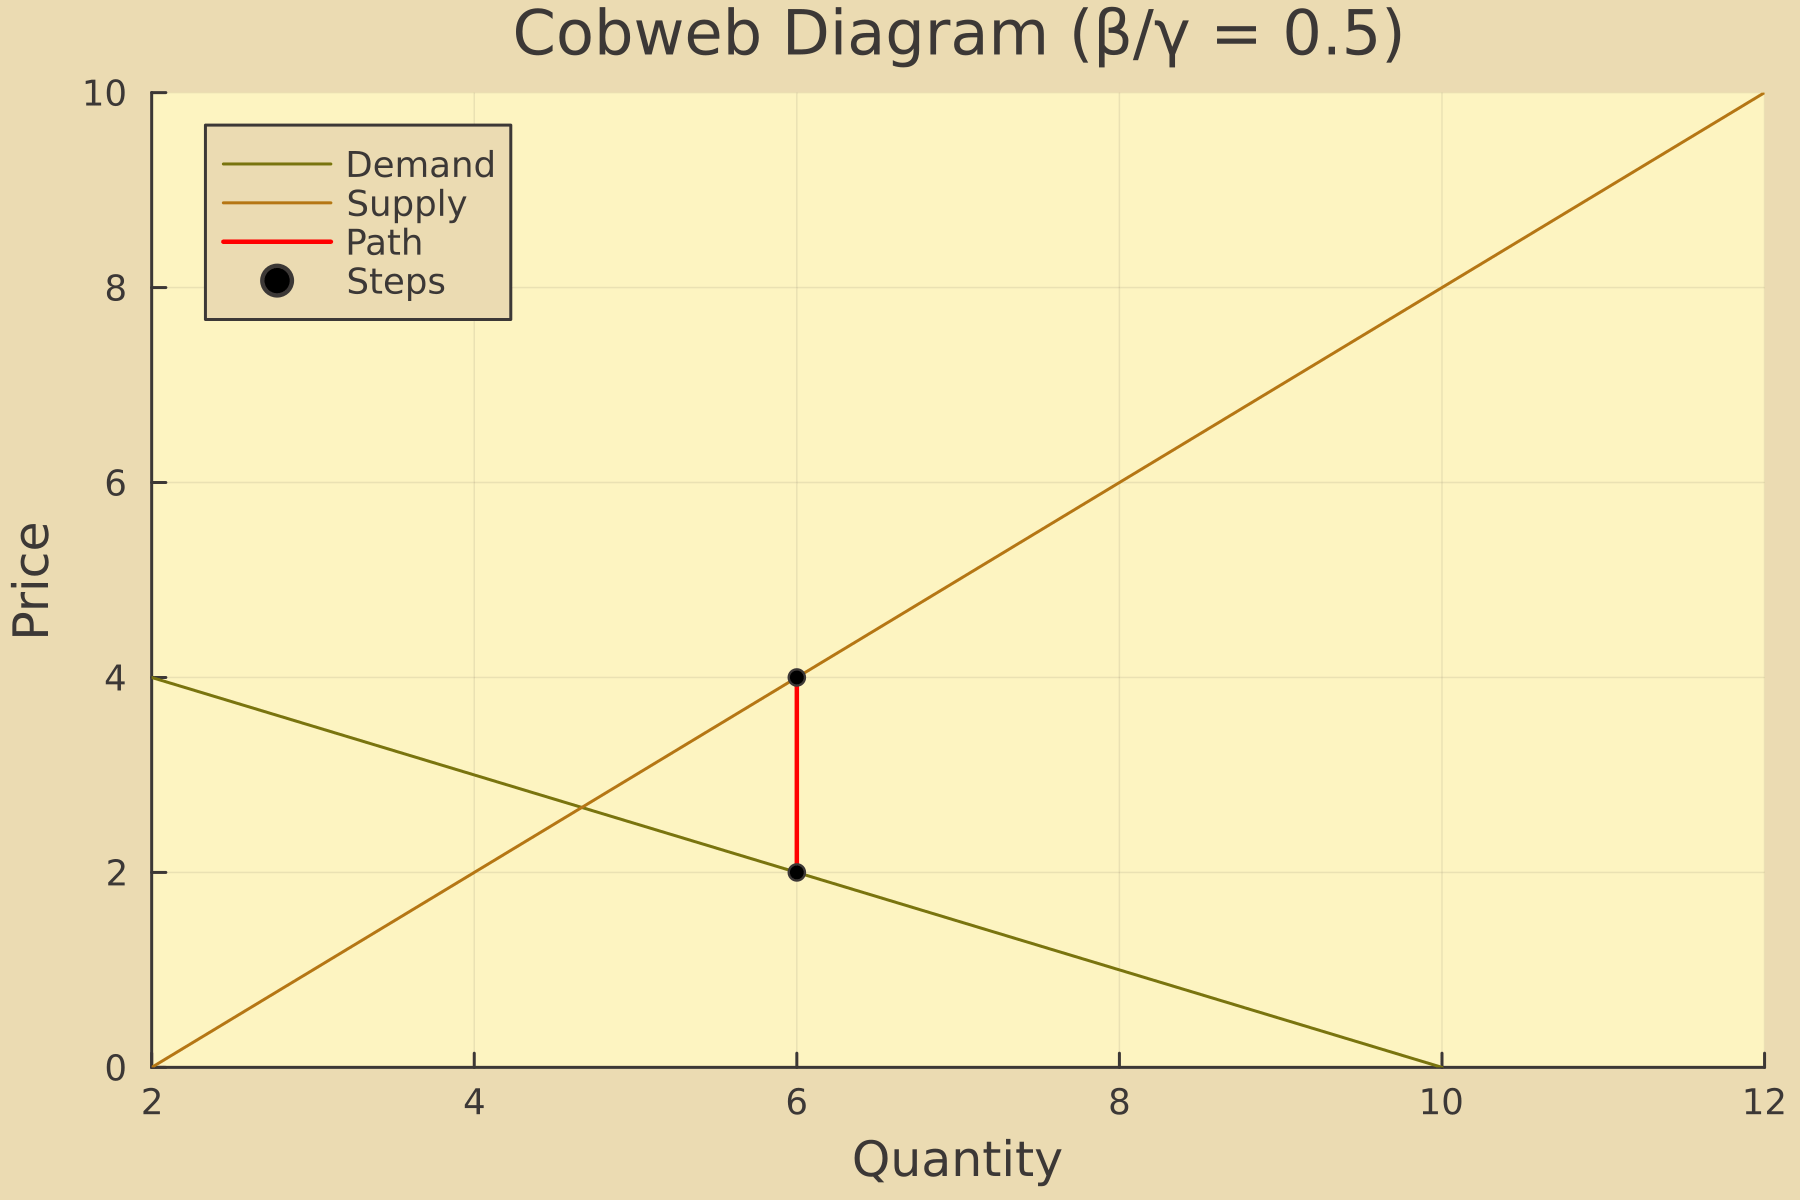

In [30]:
cobweb_diagram(params_stable, p0, 10)

### Deterministic: Unstable

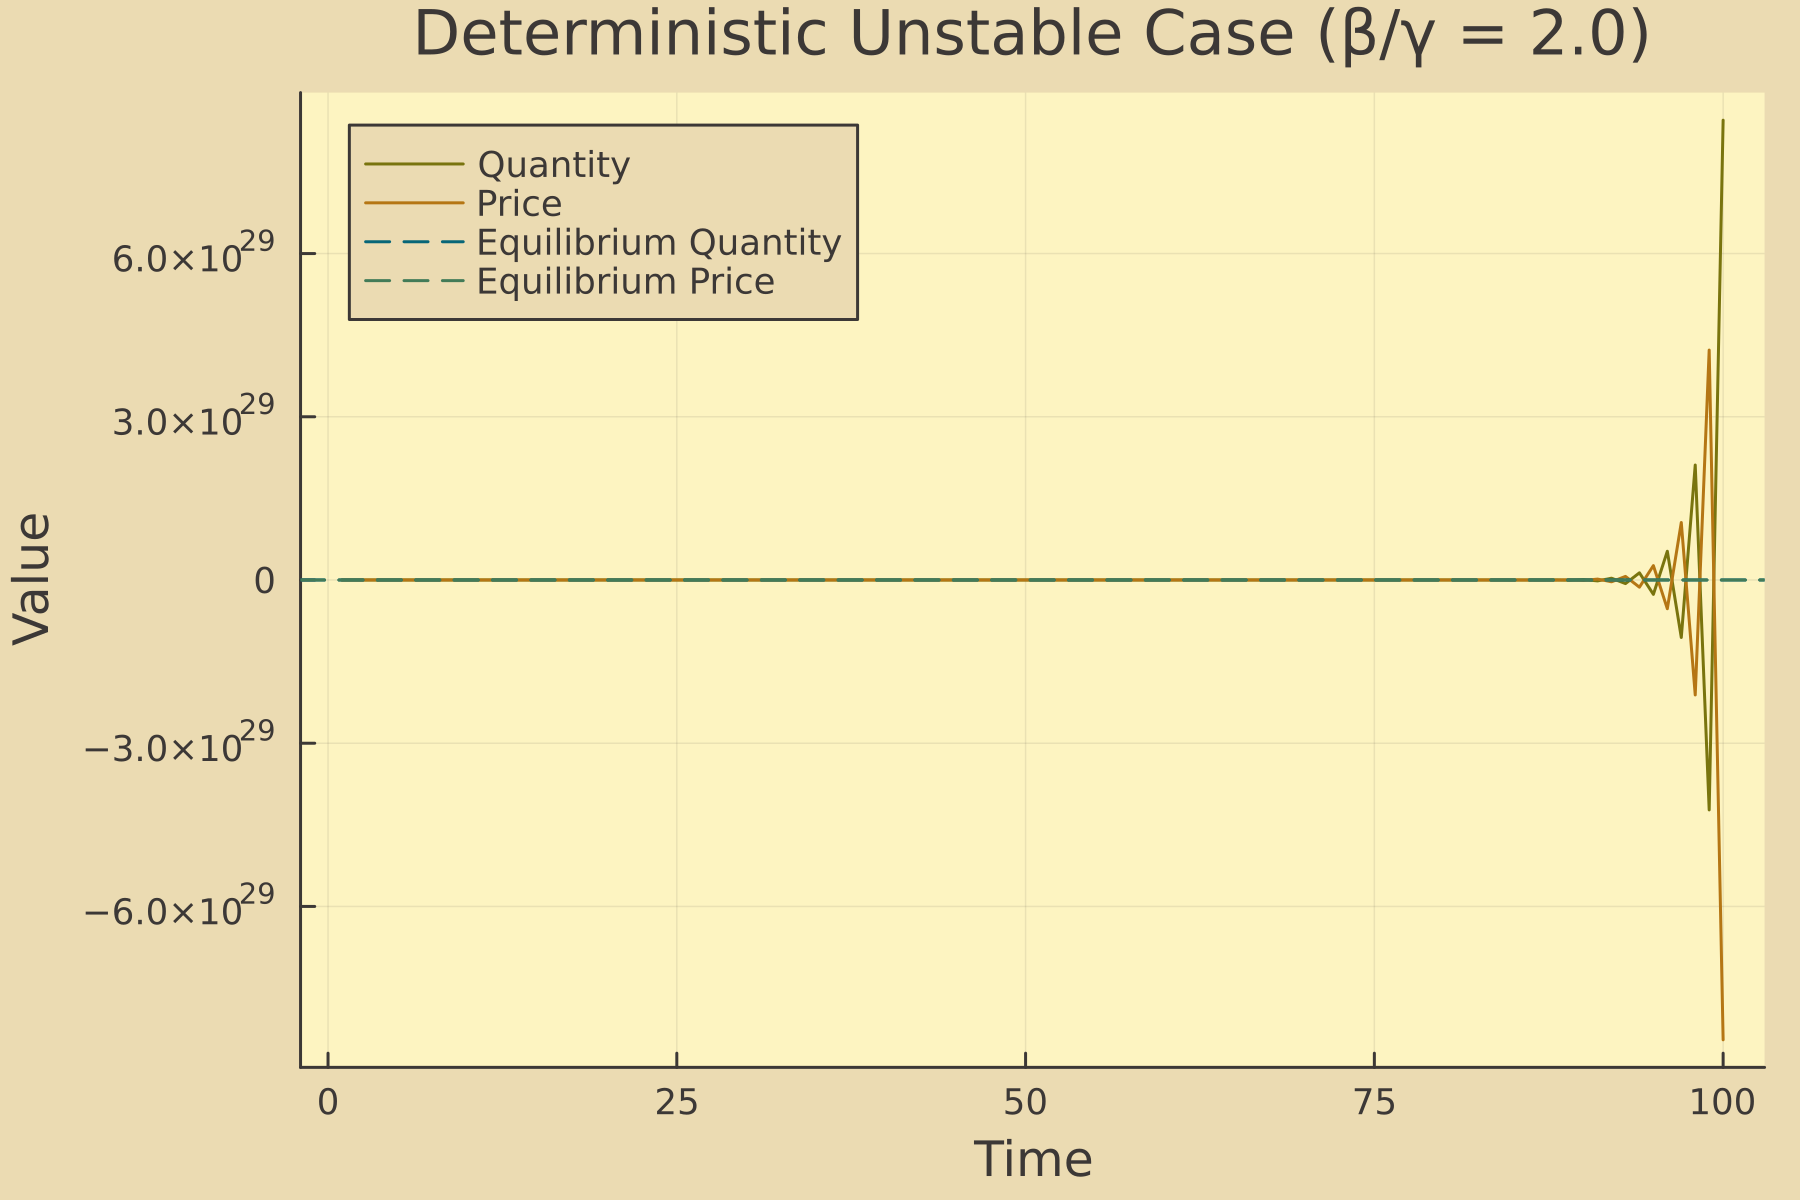

In [33]:
prices_det, quantities_det = cobweb_simulate(params_unstable, T, p0, false)
eq_price, eq_quantity = equilibrium(params_stable)

p_det_unstable = plot(1:T, quantities_det, label="Quantity", xlabel="Time", ylabel="Value", title="Deterministic Unstable Case (β/γ = 2.0)", dpi=300)
plot!(p_det_unstable, 1:T, prices_det, label="Price")
hline!(p_det_unstable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_det_unstable, [eq_price], label="Equilibrium Price", linestyle=:dash)

┌ Info: Saved animation to d:\Development\Projects\cobweb-model\images\cobweb-deterministic-2.0.gif
└ @ Plots C:\Users\ritob\.julia\packages\Plots\Ec1L1\src\animation.jl:156


Plots.AnimatedGif("d:\\Development\\Projects\\cobweb-model\\images\\cobweb-deterministic-2.0.gif")
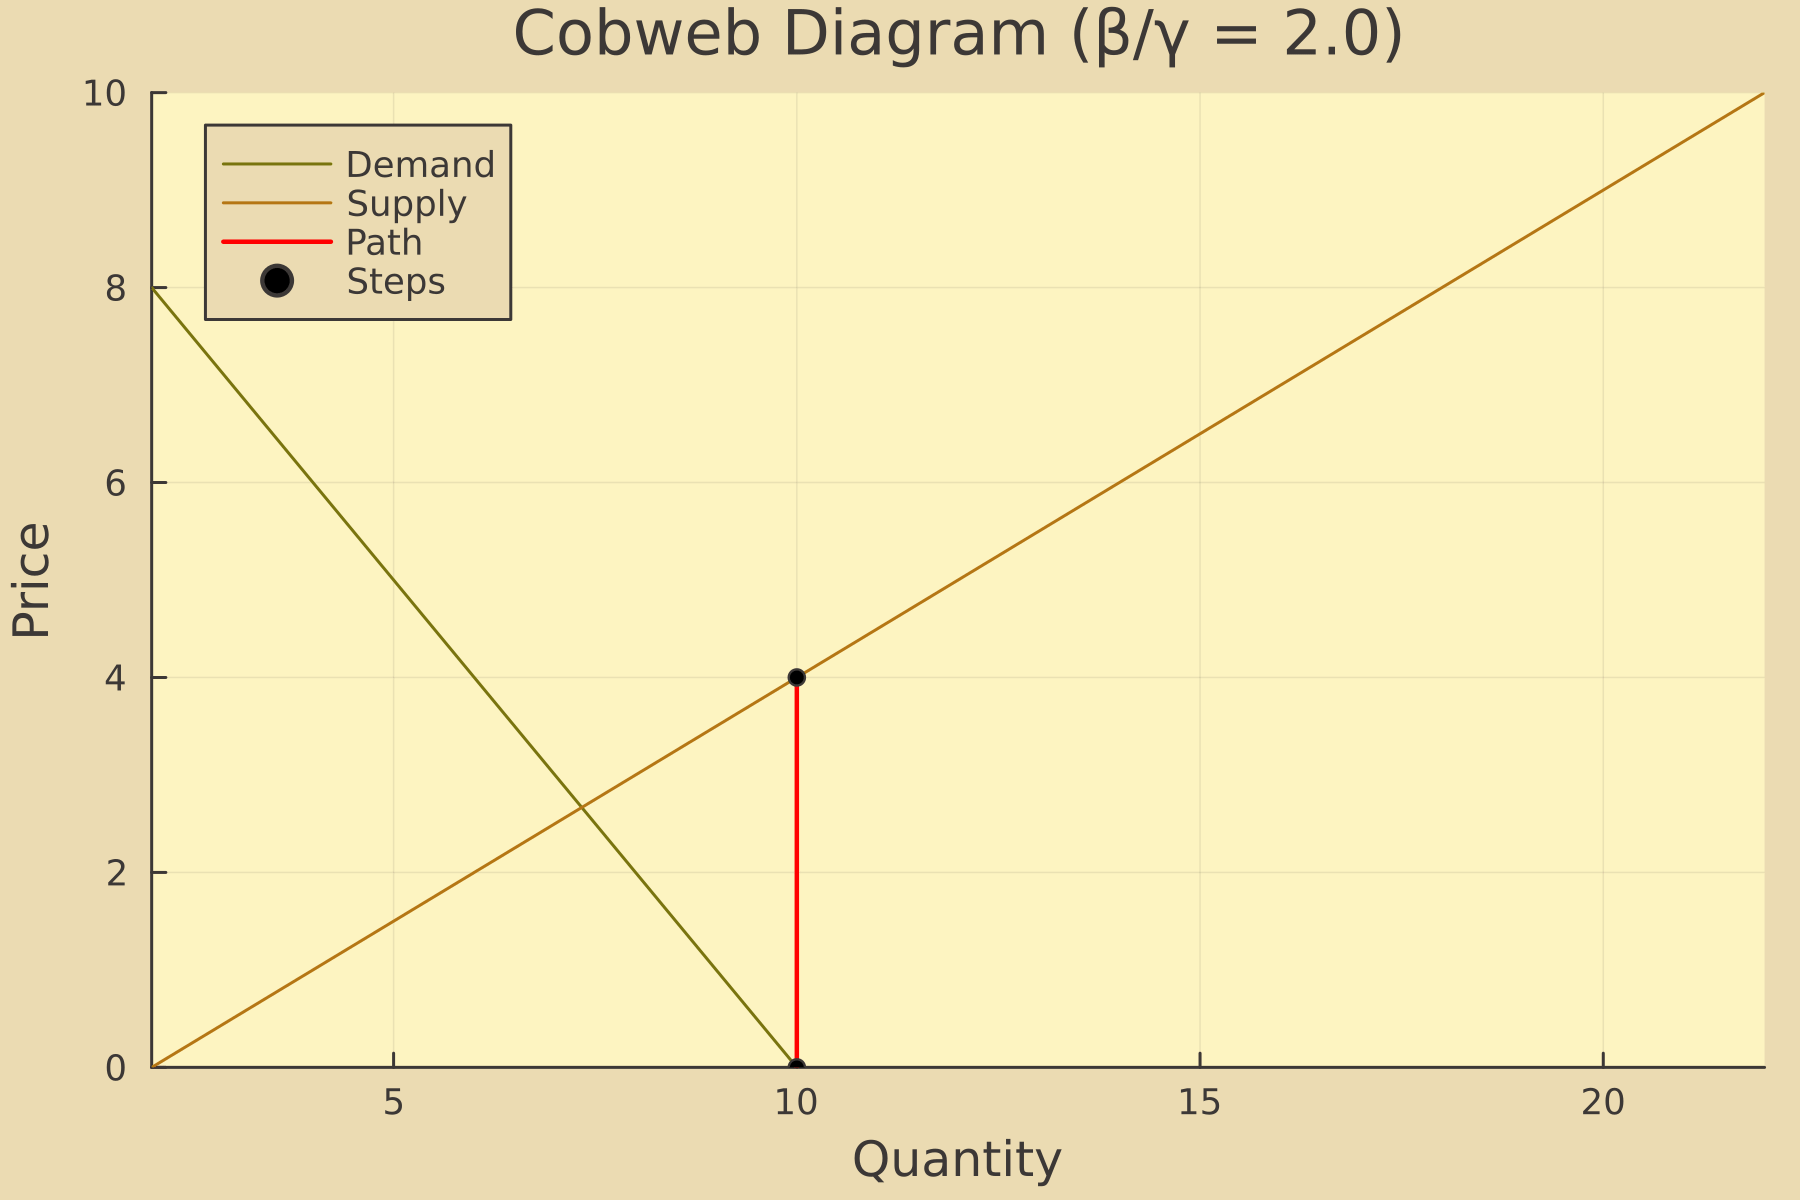

In [34]:
cobweb_diagram(params_unstable, p0, 10)

### Stochashtic Case: Stable

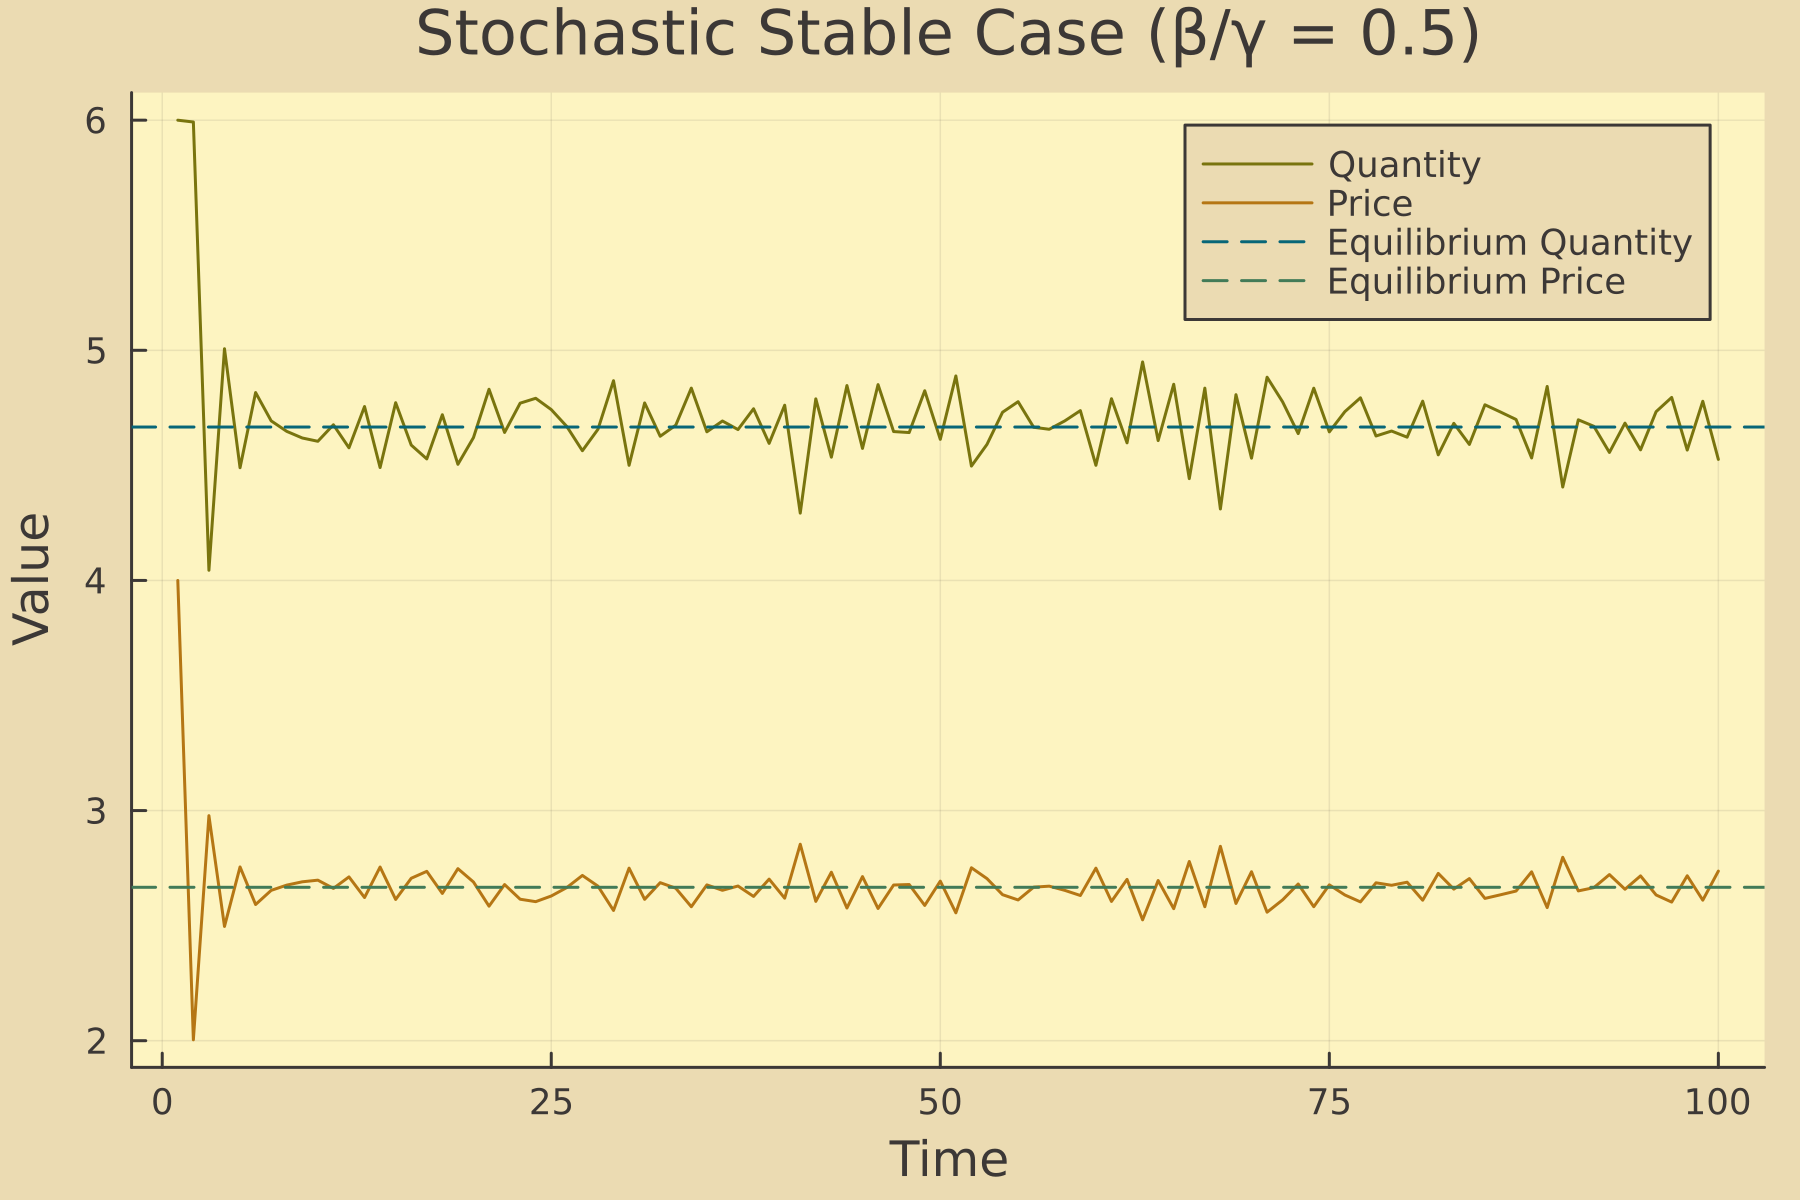

In [37]:
prices_stable, quantities_stable, shocks_stable = cobweb_simulate(params_stable, T, p0)

p_stoc_stable = plot(1:T, quantities_stable, label="Quantity", xlabel="Time", ylabel="Value", title="Stochastic Stable Case (β/γ = 0.5)", dpi=300)
plot!(p_stoc_stable, 1:T, prices_stable, label="Price")
hline!(p_stoc_stable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_stoc_stable, [eq_price], label="Equilibrium Price", linestyle=:dash)

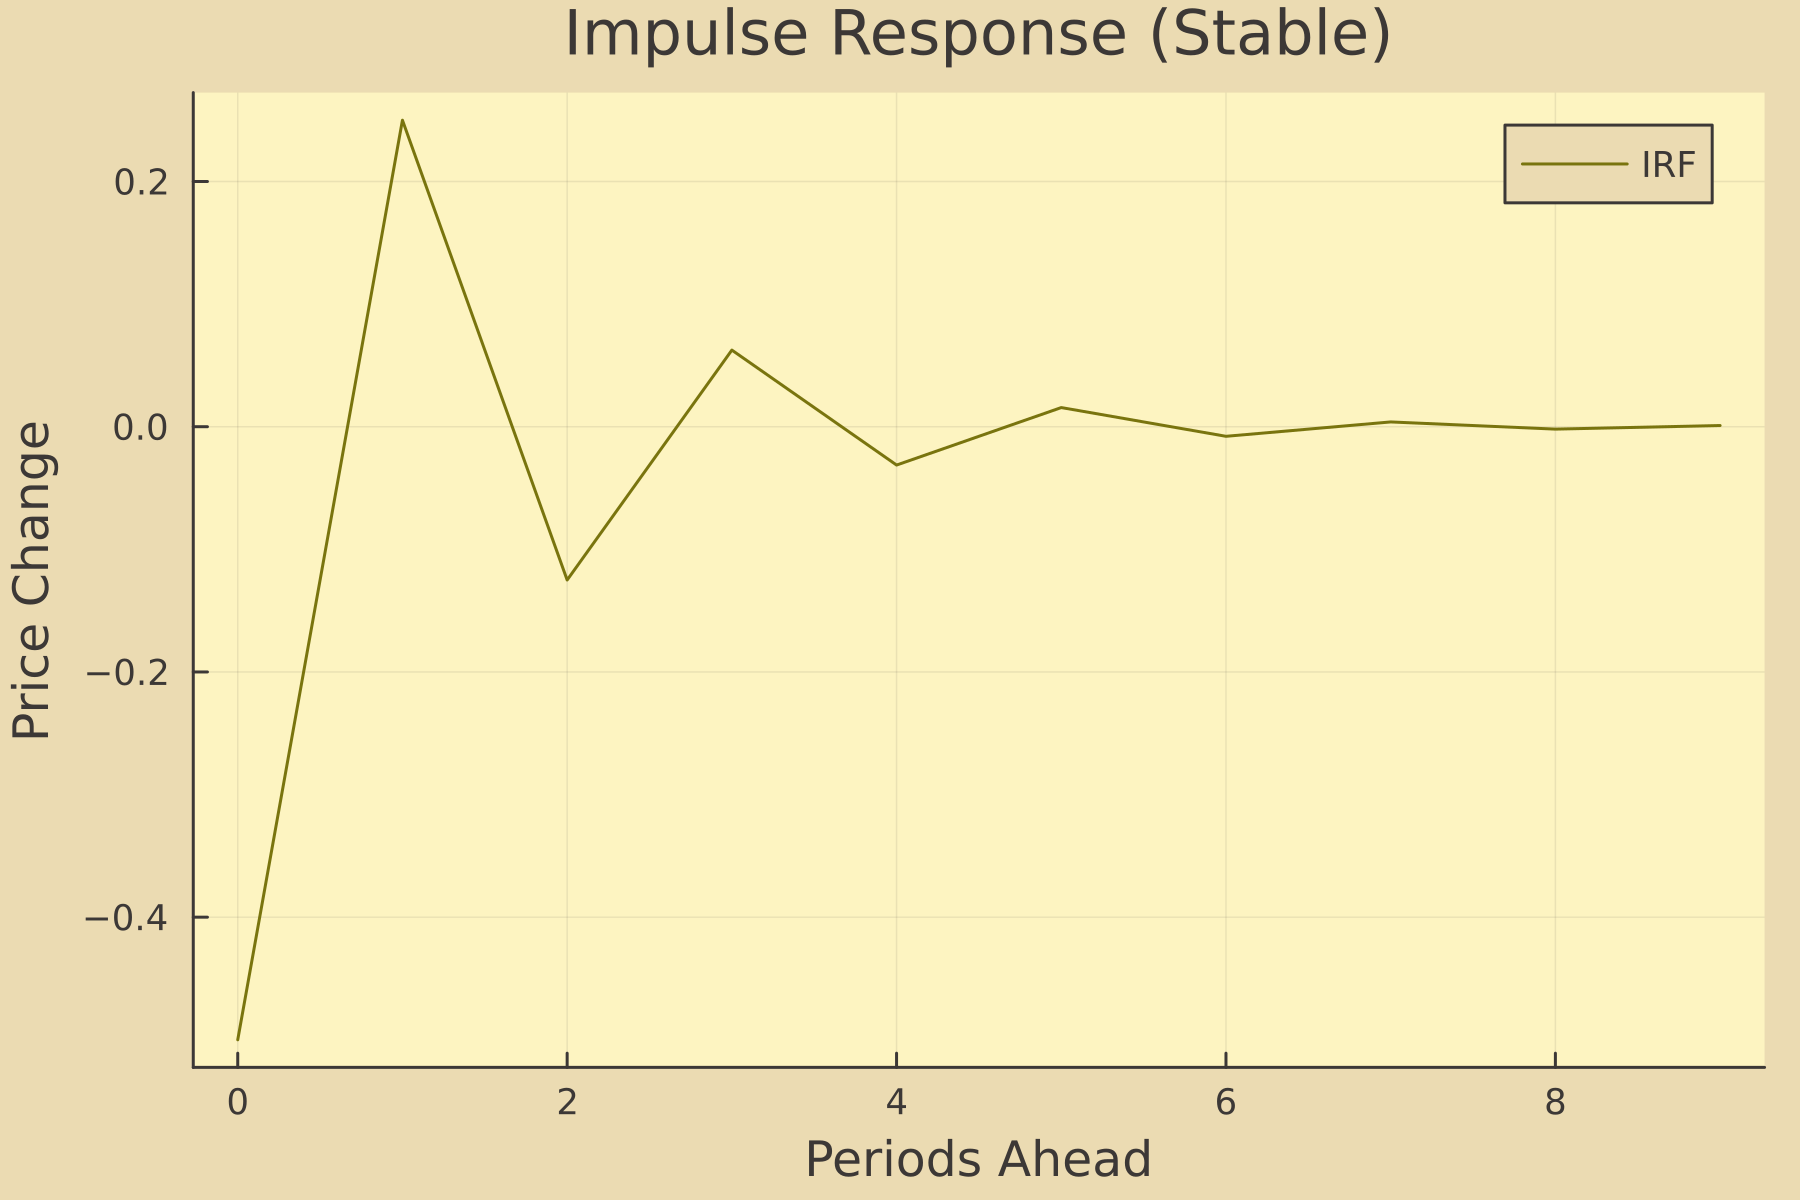

In [42]:
irf_stable = impulse_response(params_stable, horizon)
p_irf_stable = plot(0:horizon-1, irf_stable, label="IRF", xlabel="Periods Ahead", ylabel="Price Change", title="Impulse Response (Stable)", dpi=300)

### Stochashtic Case: Unstable

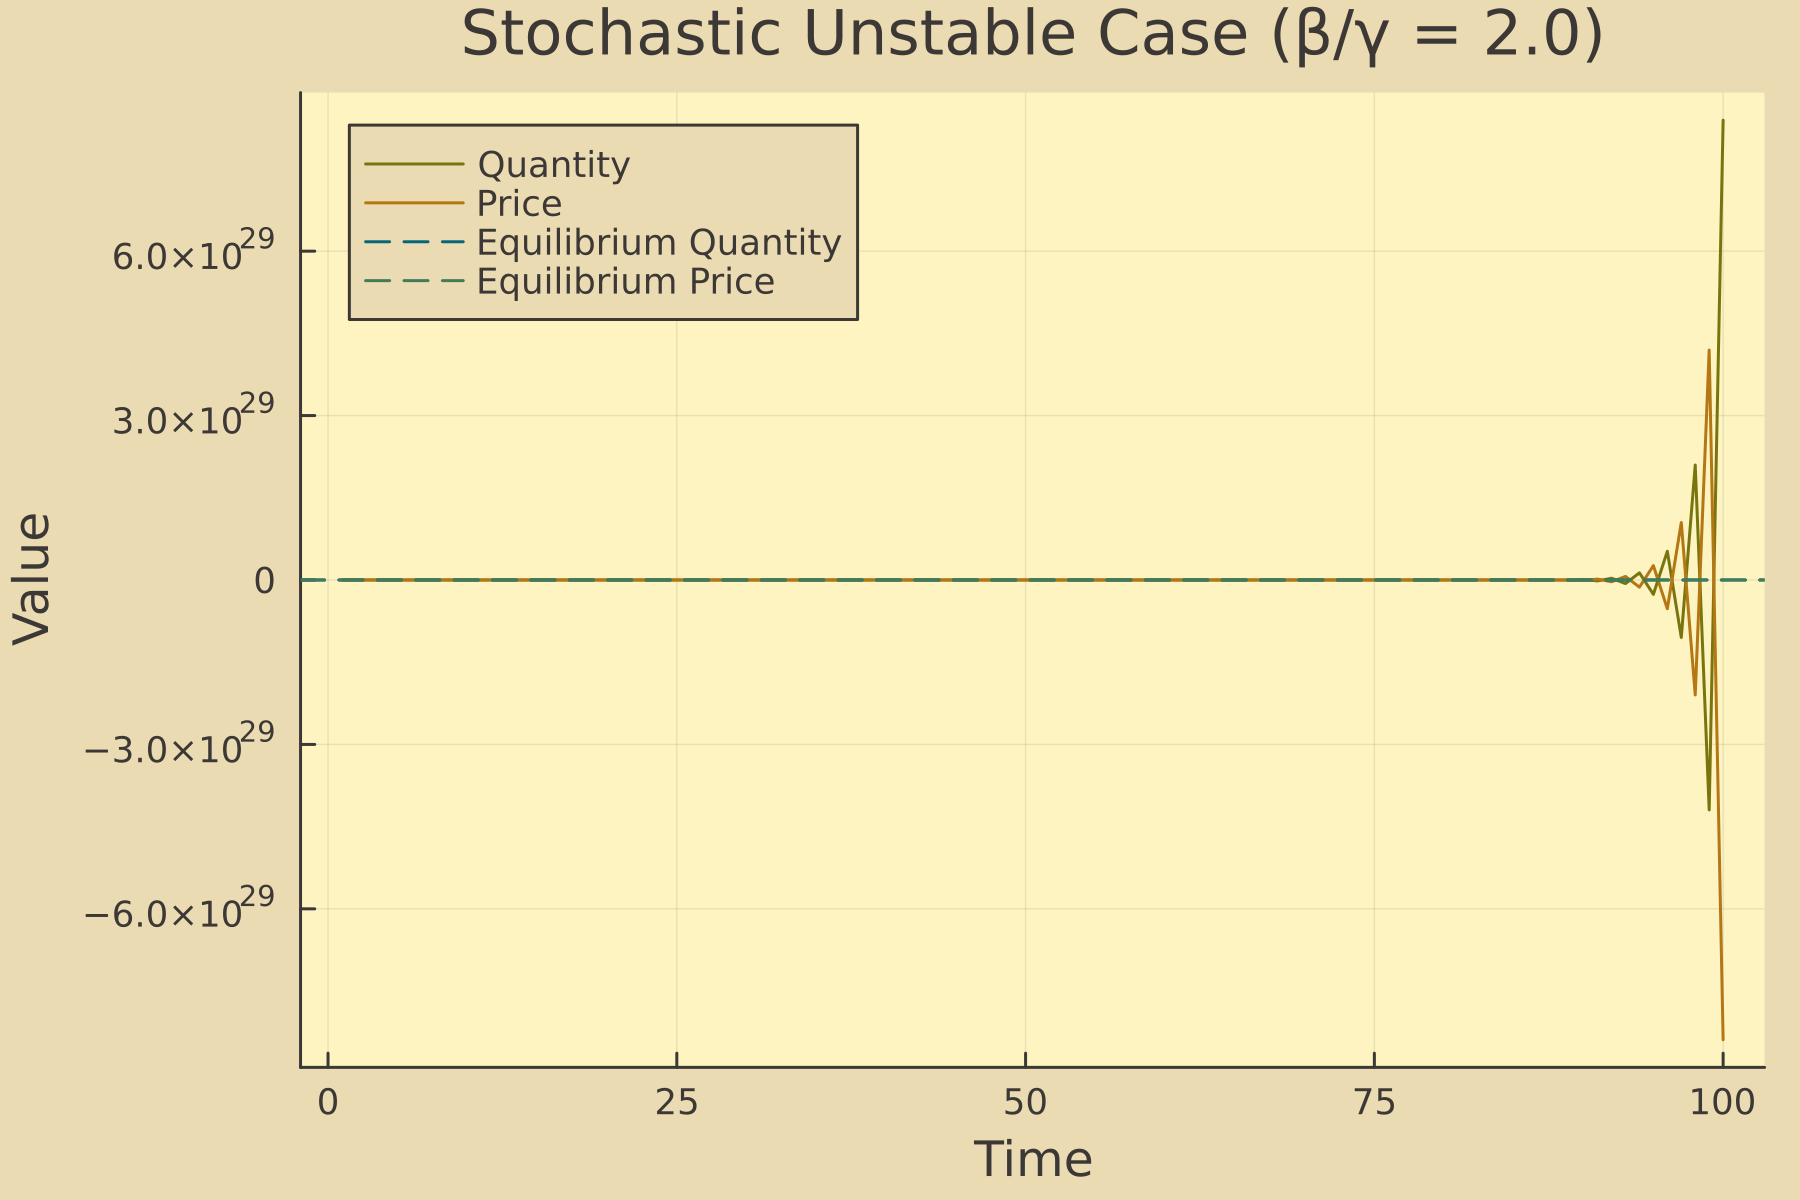

In [43]:
prices_unstable, quantities_unstable, shocks_unstable = cobweb_simulate(params_unstable, T, p0)
eq_price_unstable = (params_unstable.a - params_unstable.b) / (params_unstable.γ + params_unstable.β)

p_stoc_unstable = plot(1:T, quantities_unstable, label="Quantity", xlabel="Time", ylabel="Value", title="Stochastic Unstable Case (β/γ = 2.0)", dpi=300)
plot!(p_stoc_unstable, 1:T, prices_unstable, label="Price")
hline!(p_stoc_unstable, [eq_quantity], label="Equilibrium Quantity", linestyle=:dash)
hline!(p_stoc_unstable, [eq_price_unstable], label="Equilibrium Price", linestyle=:dash)

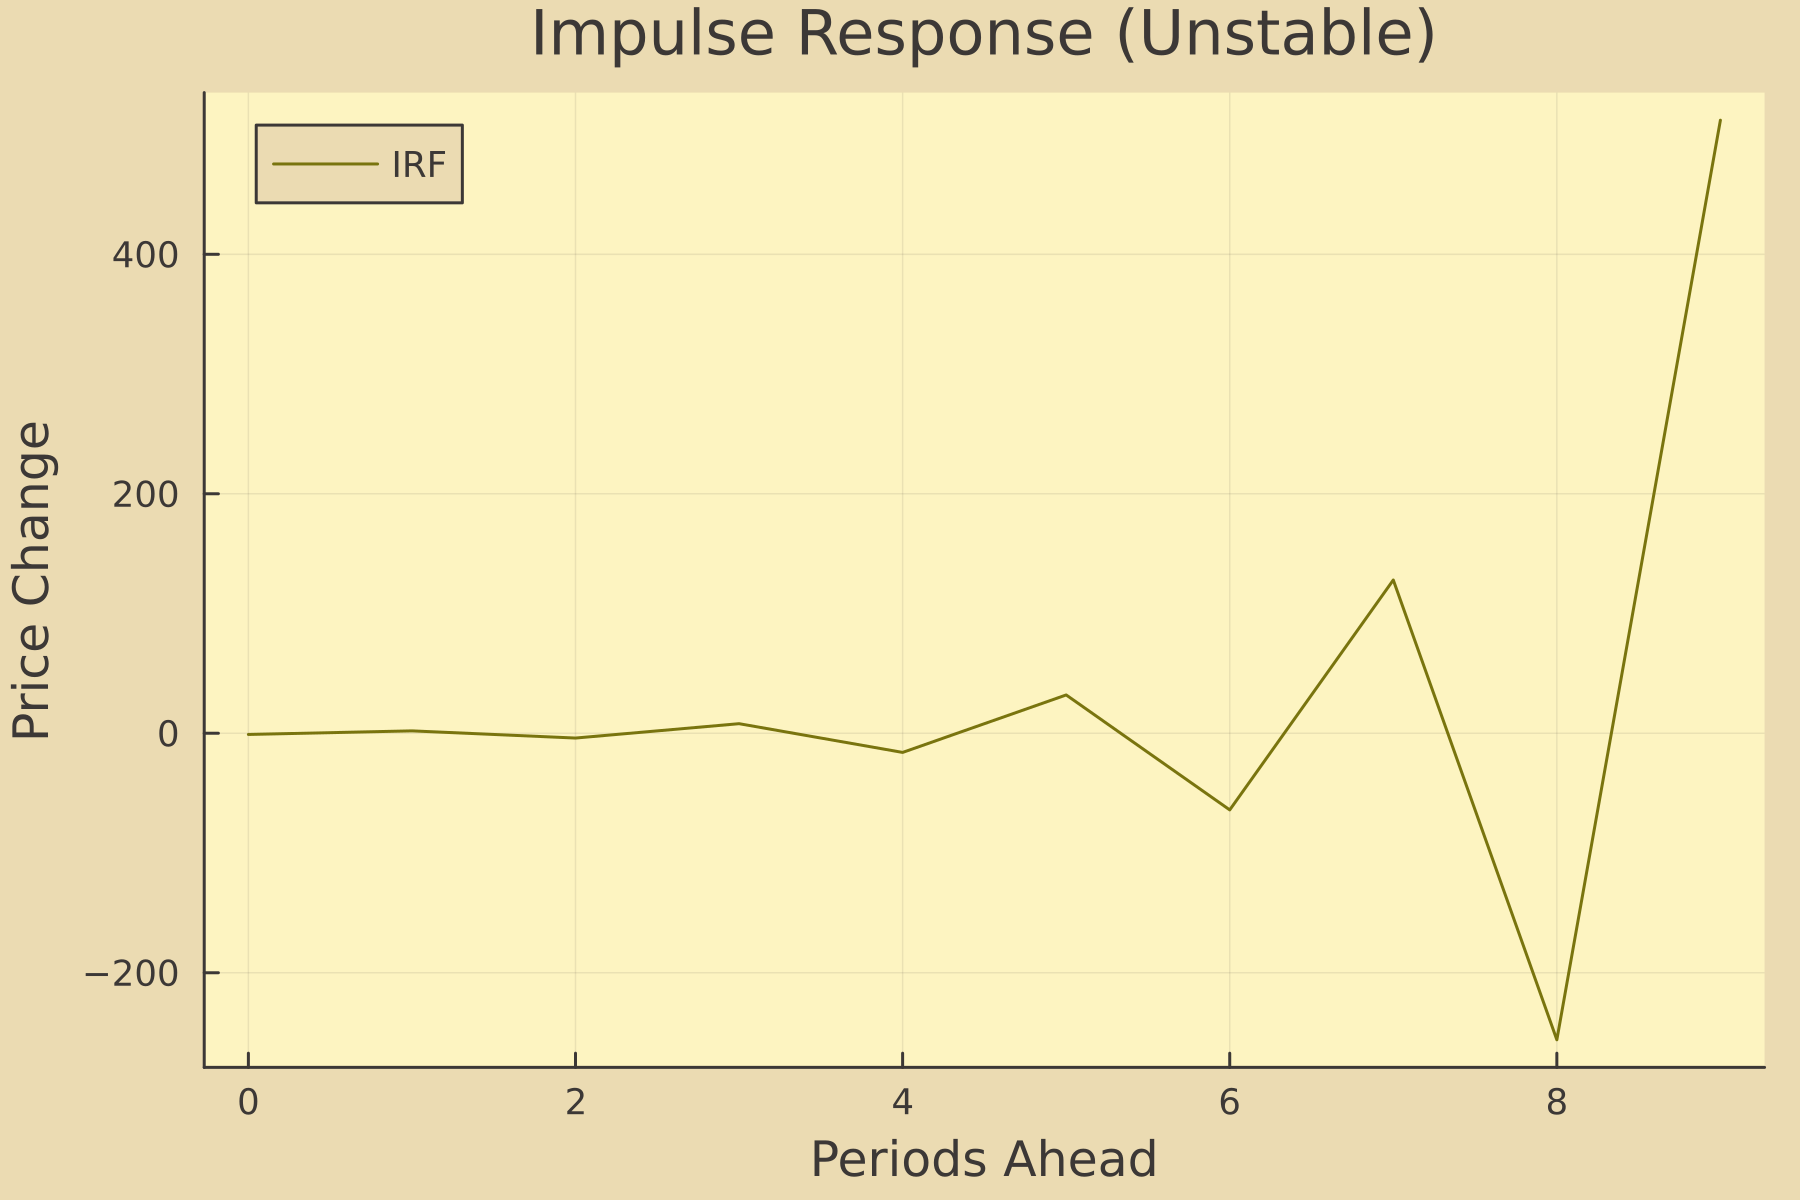

In [44]:
irf_unstable = impulse_response(params_unstable, horizon)
p_irf_unstable = plot(0:horizon-1, irf_unstable, label="IRF", xlabel="Periods Ahead", ylabel="Price Change", title="Impulse Response (Unstable)", dpi=300)

## References
- Enders, Walter. Applied Econometric Time Series. 4th ed., Wiley, 2014, pp. 18–22.

## Misc.

In [45]:
savefig(p_det_stable, "images/path-deterministic-stable.png");
savefig(p_det_unstable, "images/path-deterministic-unstable.png");
savefig(p_stoc_stable, "images/path-stochastic-stable.png");
savefig(p_stoc_unstable, "images/path-stochastic-unstable.png");
savefig(p_irf_stable, "images/irf-stable.png");
savefig(p_irf_unstable, "images/irf-unstable.png");